In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/balanced-lung-cancer-dataset/Dataset - Copy/Normal/Normal case (246).jpg
/kaggle/input/balanced-lung-cancer-dataset/Dataset - Copy/Normal/Normal case (155).jpg
/kaggle/input/balanced-lung-cancer-dataset/Dataset - Copy/Normal/Normal case (311).jpg
/kaggle/input/balanced-lung-cancer-dataset/Dataset - Copy/Normal/Normal case (45).jpg
/kaggle/input/balanced-lung-cancer-dataset/Dataset - Copy/Normal/Normal case (298).jpg
/kaggle/input/balanced-lung-cancer-dataset/Dataset - Copy/Normal/Normal case (359).jpg
/kaggle/input/balanced-lung-cancer-dataset/Dataset - Copy/Normal/Normal case (230).jpg
/kaggle/input/balanced-lung-cancer-dataset/Dataset - Copy/Normal/Normal case (2).jpg
/kaggle/input/balanced-lung-cancer-dataset/Dataset - Copy/Normal/Normal case (58).jpg
/kaggle/input/balanced-lung-cancer-dataset/Dataset - Copy/Normal/Normal case (387).jpg
/kaggle/input/balanced-lung-cancer-dataset/Dataset - Copy/Normal/Normal case (139).jpg
/kaggle/input/balanced-lung-cancer-dataset/Data

In [2]:
# This script generates a table which maps the entries in the "Balanced lung cancer dataset"...this dataset has got only two classes: [Benign, Malignant, Normal]
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
# Define the paths to the directories
malignant_images_path = '/kaggle/input/balanced-lung-cancer-dataset/Dataset - Copy/Malignant/images_new'
malignant_masks_path = '/kaggle/input/balanced-lung-cancer-dataset/Dataset - Copy/Malignant/mask_new'
benign_images_path = "/kaggle/input/balanced-lung-cancer-dataset/Dataset - Copy/Benign_new/images"
benign_masks_path  = "/kaggle/input/balanced-lung-cancer-dataset/Dataset - Copy/Benign_new/masks"
normal_images_path = '/kaggle/input/balanced-lung-cancer-dataset/Dataset - Copy/Normal'

# Initialize lists to store the data
data = {'Image_Path': [], 'Mask_Path': [], 'Label': []}

# Retrieve the paths and labels for the malignant images and masks
malignant_images = os.listdir(malignant_images_path)
malignant_masks = os.listdir(malignant_masks_path)

# Creates table for the malignant images and masks
for image in tqdm(malignant_images):
    image_path = os.path.join(malignant_images_path, image)
    mask_path = os.path.join(malignant_masks_path, image) if image in malignant_masks else None
    data['Image_Path'].append(image_path)
    data['Mask_Path'].append(mask_path)
    data['Label'].append(2)  # Label 1 for malignant
    
benign_images = os.listdir(benign_images_path)
benign_masks = os.listdir(benign_masks_path)

# Creates table for the benign images and masks
for image in tqdm(benign_images):
    image_path = os.path.join(benign_images_path, image)
    mask_path = os.path.join(benign_masks_path, image) if image in benign_masks else None
    data['Image_Path'].append(image_path)
    data['Mask_Path'].append(mask_path)
    data['Label'].append(1)  # Label 1 for malignant

# Creates table for the normal images
normal_images = os.listdir(normal_images_path)
for image in tqdm(normal_images):
    image_path = os.path.join(normal_images_path, image)
    data['Image_Path'].append(image_path)
    data['Mask_Path'].append(None)  # No mask for normal images
    data['Label'].append(0)  # Label 0 for normal

# Create a Pandas DataFrame from the data
df = pd.DataFrame(data)

# Display the DataFrame
#print(df.head(5))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
100%|██████████| 416/416 [00:00<00:00, 281242.82it/s]


In [3]:
#sanity check
print(df['Image_Path'][0])
print(df['Mask_Path'][0])
print(len(df['Mask_Path']))
print(len(df['Image_Path']))

/kaggle/input/balanced-lung-cancer-dataset/Dataset - Copy/Malignant/images_new/Malignant case (289)CroppedResized.jpg
/kaggle/input/balanced-lung-cancer-dataset/Dataset - Copy/Malignant/mask_new/Malignant case (289)CroppedResized.jpg
1608
1608


In [4]:
print(df['Label'].value_counts())

Label
2    600
1    592
0    416
Name: count, dtype: int64


In [5]:
from sklearn.model_selection import train_test_split
df_shuffled = df.sample(frac=1, random_state=42)

# Split the data into training and testing sets
train_df, test_df = train_test_split(df_shuffled, test_size=0.2, stratify=df_shuffled['Label'], random_state=42)


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [6]:
#for multiclass
import cv2
import numpy as np
import albumentations as A
from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()

class CustomDataGenerator(Sequence):
    def __init__(self, df, batch_size, image_size, shuffle=True,binary=True):
        self.df = df
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.binary=binary
        self.on_epoch_end()
        self.transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            #A.RandomBrightnessContrast(p=0.2),
            A.Rotate(limit=10, p=0.3)
        ])

    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __getitem__(self, index):
        batch_df = self.df[index * self.batch_size : (index + 1) * self.batch_size]

        images = []
        masks = []
        labels = []

        for i, row in batch_df.iterrows():
            if self.binary==True:
                image = cv2.imread(row['Image_Path'], cv2.IMREAD_GRAYSCALE)
            else:
                image = cv2.imread(row['Image_Path'], cv2.IMREAD_COLOR)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, self.image_size)
            #shape = image.shape
            #image = scaler.fit_transform(image.reshape(-1, shape[-1])).reshape(shape)
            image = image/255.0
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            mask_path = row['Mask_Path']
            if mask_path:
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, self.image_size)
                mask=mask/255.0
                mask[mask>0.7]=1
                #mask[mask>0.1]=1
            else:
                mask = np.zeros(self.image_size, dtype=np.uint8)

            label = row['Label']

            augmented = self.transform(image=image, mask=mask)
            images.append(augmented['image'])
            masks.append(augmented['mask'])
            if(label==2):
                labels.append([1,0,0])
            if(label==1):
                labels.append([0,1,0])
            if(label==0):
                labels.append([0,0,1])
                

        #images = np.expand_dims(np.array(images, dtype=np.float32), axis=-1)
        images = np.array(images, dtype=np.float32)
        masks = np.expand_dims(np.array(masks, dtype=np.float32), axis=-1)
        #labels = np.expand_dims(np.array(labels, dtype=np.float32),axis=-1)
        labels = np.array(labels,dtype=np.float32)

        #return {"input_9": images}, {"segmentation_output": masks, "classifier_output": labels}
        return  images, [masks, labels]

# Example usage of the CustomDataGenerator
train_generator = CustomDataGenerator(train_df, batch_size=8, image_size=(256, 256), shuffle=True, binary=True)

[1. 0. 0.]
[0. 0. 1.]
[0. 1. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]


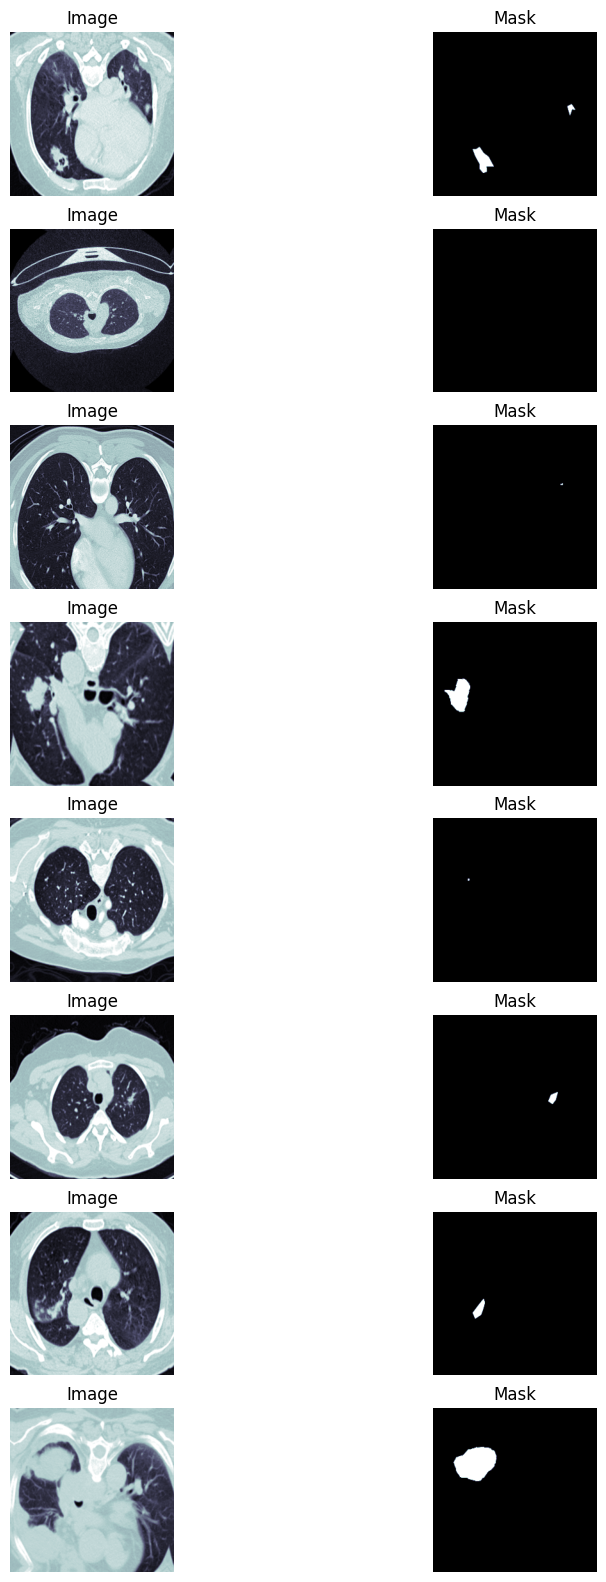

In [7]:
import matplotlib.pyplot as plt

# Load a single batch
batch = train_generator[0]  # Assuming you want to load the first batch

# Extract images and labels from the batch
images, labels = batch

# Display the images and masks
n_images_to_display = len(images)
fig, ax = plt.subplots(n_images_to_display, 2, figsize=(10, 20))
for i in range(n_images_to_display):
    print(labels[1][i])
    ax[i, 0].imshow(images[i], cmap='bone')
    ax[i, 0].set_title('Image')
    ax[i, 1].imshow(labels[0][i], cmap='bone')
    ax[i, 1].set_title('Mask')

    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
plt.show()

In [8]:
!pip -q install tensorflow-wavelets

In [9]:
import tensorflow_wavelets.Layers.DWT as DWT
import tensorflow_wavelets.Layers.DTCWT as DTCWT
import tensorflow_wavelets.Layers.DMWT as DMWT

In [10]:
tf.config.run_functions_eagerly(True)

In [11]:
import pywt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow_wavelets.utils.helpers import *
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # for tensor flow warning
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'


class DWT(layers.Layer):
    """
    Discrete Wavelet transform - tensorflow - keras
    inputs:
        name - wavelet name ( from pywavelet library)
        concat - 1 - merge transform output to one channel
               - 0 - split to 4 channels ( 1 img in -> 4 smaller img out)
    """

    def __init__(self, wavelet_name='haar', concat=1, **kwargs):
        super(DWT, self).__init__(**kwargs)
        # self._name = self.name + "_" + name
        # get filter coeffs from 3rd party lib
        wavelet = pywt.Wavelet(wavelet_name)
        self.dec_len = wavelet.dec_len
        self.concat = concat
        # decomposition filter low pass and hight pass coeffs
        db2_lpf = wavelet.dec_lo
        db2_hpf = wavelet.dec_hi

        # covert filters into tensors and reshape for convolution math
        db2_lpf = tf.constant(db2_lpf[::-1])
        self.db2_lpf = tf.reshape(db2_lpf, (1, wavelet.dec_len, 1, 1))

        db2_hpf = tf.constant(db2_hpf[::-1])
        self.db2_hpf = tf.reshape(db2_hpf, (1, wavelet.dec_len, 1, 1))

        self.conv_type = "VALID"
        self.border_padd = "SYMMETRIC"

    def build(self, input_shape):
        # filter dims should be bigger if input is not gray scale
        if input_shape[-1] != 1:
            # self.db2_lpf = tf.repeat(self.db2_lpf, input_shape[-1], axis=-1)
            self.db2_lpf = tf.keras.backend.repeat_elements(self.db2_lpf, input_shape[-1], axis=-1)
            # self.db2_hpf = tf.repeat(self.db2_hpf, input_shape[-1], axis=-1)
            self.db2_hpf = tf.keras.backend.repeat_elements(self.db2_hpf, input_shape[-1], axis=-1)

    def call(self, inputs, training=None, mask=None):

        # border padding symatric add coulums
        inputs_pad = tf.pad(inputs, [[0, 0], [0, 0], [self.dec_len-1, self.dec_len-1], [0, 0]], self.border_padd)

        # approximation conv only rows
        a = tf.nn.conv2d(
            inputs_pad, self.db2_lpf, padding=self.conv_type, strides=[1, 1, 1, 1],
        )
        # details conv only rows
        d = tf.nn.conv2d(
            inputs_pad, self.db2_hpf, padding=self.conv_type, strides=[1, 1, 1, 1],
        )
        # ds - down sample
        a_ds = a[:, :, 1:a.shape[2]:2, :]
        d_ds = d[:, :, 1:d.shape[2]:2, :]

        # border padding symatric add rows
        a_ds_pad = tf.pad(a_ds, [[0, 0], [self.dec_len-1, self.dec_len-1], [0, 0], [0, 0]], self.border_padd)
        d_ds_pad = tf.pad(d_ds, [[0, 0], [self.dec_len-1, self.dec_len-1], [0, 0], [0, 0]], self.border_padd)

        # convolution is done on the rows so we need to
        # transpose the matrix in order to convolve the colums
        a_ds_pad = tf.transpose(a_ds_pad, perm=[0, 2, 1, 3])
        d_ds_pad = tf.transpose(d_ds_pad, perm=[0, 2, 1, 3])

        # aa approximation approximation
        aa = tf.nn.conv2d(
            a_ds_pad, self.db2_lpf, padding=self.conv_type, strides=[1, 1, 1, 1],
        )
        # ad approximation details
        ad = tf.nn.conv2d(
            a_ds_pad, self.db2_hpf, padding=self.conv_type, strides=[1, 1, 1, 1],
        )
        # ad details aproximation
        da = tf.nn.conv2d(
            d_ds_pad, self.db2_lpf, padding=self.conv_type, strides=[1, 1, 1, 1],
        )
        # dd details details
        dd = tf.nn.conv2d(
            d_ds_pad, self.db2_hpf, padding=self.conv_type, strides=[1, 1, 1, 1],
        )

        # transpose back the matrix
        aa = tf.transpose(aa, perm=[0, 2, 1, 3])
        ad = tf.transpose(ad, perm=[0, 2, 1, 3])
        da = tf.transpose(da, perm=[0, 2, 1, 3])
        dd = tf.transpose(dd, perm=[0, 2, 1, 3])

        # down sample
        ll = aa[:, 1:aa.shape[1]:2, :, :]
        lh = ad[:, 1:ad.shape[1]:2, :, :]
        hl = da[:, 1:da.shape[1]:2, :, :]
        hh = dd[:, 1:dd.shape[1]:2, :, :]

        # concate all outputs ionto tensor
        if self.concat == 0:
            x = tf.concat([ll, lh, hl, hh], axis=-1)
            #x = tf.concat([ll, lh, hl], axis=-1)
        else:
            #x = tf.concat([tf.concat([ll, lh], axis=1), tf.concat([hl, hh], axis=1)], axis=2)
            x = ll
        return x


In [12]:
def GCSE(input_tensor, ratio=16):
    
  
    # Compute the global statistics (mean and std deviation) along the channel axis.
    mean = tf.reduce_mean(input_tensor, axis=[1, 2], keepdims=True)
    std = tf.math.reduce_std(input_tensor, axis=[1, 2], keepdims=True)
    
    # Compute channel-wise attention using a convolutional neural network.
    attn_channel = tf.concat([mean, std], axis=-1)
    attn_channel = tf.keras.layers.Conv2D(filters=input_tensor.shape[-1] // ratio, kernel_size=(1, 1), activation='relu')(attn_channel)
    attn_channel = tf.keras.layers.Conv2D(filters=input_tensor.shape[-1], kernel_size=(1, 1), activation='sigmoid')(attn_channel)
    
    # Compute spatial attention using global information from the input tensor.
    global_info = tf.reduce_mean(input_tensor, axis=-1, keepdims=True)
    attn_spatial = tf.keras.layers.Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(global_info)
    
    # Combine channel-wise and spatial attention.
    attn = tf.keras.layers.Multiply()([attn_channel,attn_spatial])
    
    # Multiply the input tensor by the learned attention weights.
    output_tensor = tf.keras.layers.Multiply()([input_tensor,attn])
    
    return output_tensor

In [13]:


def conditional_segmentation(input_tensor, classification_output):
    # Extract probabilities for Malignant, Benign, and Normal classes
    malignant_prob = classification_output[:, 0]
    benign_prob = classification_output[:, 1]
    normal_prob = classification_output[:, 2]

    # Compute a conditional weight for each pixel based on the likelihood of being normal
    conditional_weight = 1.0 - normal_prob

    # Apply the conditional weight to the segmentation output
    conditional_segmentation_output = Multiply()([input_tensor, conditional_weight[:, tf.newaxis, tf.newaxis, :]])

    return conditional_segmentation_output

def build_Y_Net_np(input_shape):
    inputs = Input(input_shape)

    # ... (rest of the model architecture)

    """ Seg_Output """
    segmentation_output = Conv2D(1, 1, padding="same", activation="sigmoid", name='segmentation_output')(d4)

    # Use the conditional_segmentation function to adjust the segmentation output
    conditional_segmentation_output = Lambda(lambda x: conditional_segmentation(x[0], x[1]), name='conditional_segmentation_output')([segmentation_output, classifier_output])

    # Use the conditional_classification function to modulate the classifier input
    conditional_classifier_output = Lambda(lambda x: conditional_classification(x[0], x[1]), name='conditional_classifier_output')([classifier_arm, segmentation_output])

    model = Model(inputs=inputs, outputs=[conditional_segmentation_output, conditional_classifier_output], name="composite_model")
    return model


In [14]:
#Architecture for Residual_UNet with DWT pooling
from tensorflow.keras.layers import Conv2D,Conv2DTranspose, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Input, ZeroPadding2D,Dropout,Dense,MaxPooling2D,Reshape,Multiply,GlobalAveragePooling2D,AveragePooling2D,Lambda,Flatten
from tensorflow.keras.models import Model
import pywt
from keras.layers import Lambda

def batchnorm_relu(inputs):
    x = BatchNormalization(axis=-1)(inputs)
    x = Activation("relu")(x)
    return x

def residual_block(inputs, num_filters):
    """ Convolutional Layer """
    x = batchnorm_relu(inputs)
    x = Conv2D(num_filters, 3, padding="same", strides=1,kernel_initializer = "he_normal")(x)
    x = Dropout(0.1)(x)
    x = batchnorm_relu(x)
    x = Conv2D(num_filters, 3, padding="same", strides=1,kernel_initializer = "he_normal")(x)

    """ Shortcut Connection """
    s = Conv2D(num_filters, 1, padding="same", strides=1,kernel_initializer="he_normal")(inputs)
    x = x + s
    return x

def decoder_block(inputs, skip_features, num_filters,attention=True):
    x = Conv2DTranspose(num_filters,2, strides=(2,2), kernel_initializer="he_normal",padding = "same")(inputs)
    x = Concatenate()([x, skip_features])
    x = residual_block(x, num_filters)
    if attention==True:
        x = GCSE(x)
    return x
def conditional_segmentation(input_tensor, classification_output):
    # Extract probabilities for Malignant, Benign, and Normal classes
    malignant_prob = classification_output[:, 0]
    benign_prob = classification_output[:, 1]
    normal_prob = classification_output[:, 2]

    # Compute a conditional weight for each pixel based on the likelihood of being normal
    conditional_weight = 1.0 - normal_prob

    # Apply the conditional weight to the segmentation output
    conditional_segmentation_output = Multiply()([input_tensor, conditional_weight[:, tf.newaxis, tf.newaxis, :]])

    return conditional_segmentation_output

def build_Y_Net_np(input_shape):
    inputs = Input(input_shape)
    
    #integrating augmentation directly into the model
    #x = tf.keras.layers.RandomContrast(0.15)(inputs)
    #x = tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2)(x)
    #x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
    #x_ = tf.keras.layers.RandomZoom(0.3)(x)
    f = [16 , 32, 64, 128]

    """ Encoder 1 """
    x = Conv2D(f[0], 3, padding="same", strides=1,kernel_initializer="he_normal")(inputs)
    x = batchnorm_relu(x)
    x = Conv2D(f[0], 3, padding="same", strides=1,kernel_initializer="he_normal")(x)
    s = Conv2D(f[0], 1, padding="same", strides=1,kernel_initializer="he_normal")(inputs)
    
    c1 = x + s
    #c1 = GCSE(c1)
    #p1 = Lambda(lambda x: DWT.DWT(wavelet_name="db1", concat=1)(x), name='DWT_1')(c1)[:,0:128,0:128,:]
    #p1 = Lambda(lambda x: wavelet_downsampling(x))(c1)
    #p1_lambda = DWTLayer(wavelet_name="db1", concat=1, name='DWT_1')(c1)
    #p1 = p1_lambda[:, 0:128, 0:128, :]
    #p1_ = DWT.DWT(name="db1",concat=1)(c1)
    #p1 = p1_[:,0:128,0:128,:]
    #p1 = WaveletDownsampling()(c1)
    p1 = DWT(wavelet_name='db1', concat=0, name='pool_1')(c1)
    p1 = GCSE(p1)
    #p1 = MaxPooling2D((2,2))(c1)
    s1 = c1

    """ Encoder 2 and 3 """
    c2 = residual_block(p1, f[1])
    #c2 = GCSE(c2)
    #p2 = Lambda(lambda x: DWT.DWT(wavelet_name="db1", concat=1)(x), name='DWT_2')(c2)[:,0:64,0:64,:]
    #p2 = Lambda(lambda x: pywt.dwt2(x,'db1')[0], name='DWT_2')(c2)
    #p2 = DWTLayer(wavelet_name="db1", concat=1, name='DWT_1')((c2))[:,0:64,0:64,:]
    p2 = DWT(wavelet_name="db1",concat=0,name = 'pool_2')(c2)
    p2 = GCSE(p2)
    #p2 = MaxPooling2D((2,2))(c2)
    #p2 = p2_[:,0:64,0:64,:]
    s2 = c2
    
    c3 = residual_block(p2, f[2])
    #c3 = GCSE(c3)
    #p3 = Lambda(lambda x: DWT.DWT(wavelet_name="db1", concat=1)(x), name='DWT_3')(c3)[:,0:32,0:32,:]
    #p3 = Lambda(lambda x: pywt.dwt2(x,'db1')[0], name='DWT_3')(c3)
    #p3 = DWTLayer(wavelet_name="db1", concat=1, name='DWT_1')(c3)[:,0:32,0:32,:]
    p3 = DWT(wavelet_name="db1",concat=0,name = 'pool_3')(c3)
    p3 = GCSE(p3)
    #p3 = MaxPooling2D((2,2))(c3)
    s3 = c3

    c4 = residual_block(p3, f[3])
    #c4 = GCSE(c4)
    #p4 = Lambda(lambda x: DWT.DWT(wavelet_name="db1", concat=1)(x), name='DWT_4')(c4)[:,0:16,0:16,:]
    #p4 = Lambda(lambda x: pywt.dwt2(x,'db1')[0], name='DWT_4')(c4)
    #p4 = DWTLayer(wavelet_name="db1", concat=1, name='DWT_1')(c4)[:,0:16,0:16,:]
    p4 = DWT(wavelet_name="db1",concat=0,name = 'pool_4')(c4)
    p4 = GCSE(p4)
    #p4= MaxPooling2D((2,2))(c4)
    s4 = c4

    """ Bridge """
    b = residual_block(p4,256)
    #b = p4

    """ Decoder 1, 2, 3 """
    d1 = decoder_block(b, s4, f[3])
    d2 = decoder_block(d1, s3, f[2])
    d3 = decoder_block(d2, s2, f[1])
    d4 = decoder_block(d3, s1, f[0],attention=False)

    """Classifier"""
    """"classifier_arm = Flatten()(b)
        classifier_arm = Dense(f[2], activation='relu')(classifier_arm)
        classifier_output = Dense(3, activation='softmax', name='classifier_output')(classifier_arm)"""
    l1 = GlobalAveragePooling2D()(b)
    l2 = GlobalAveragePooling2D()(d4)
    classifier_arm = Concatenate()([l1,l2])
    classifier_arm = Dense(f[2], activation='relu')(classifier_arm)
    classifier_output = Dense(3, activation='softmax', name='classifier_output')(classifier_arm)

    """ Seg_Output """
    conditioning_weight = Dense(1,activation='sigmoid')(classifier_output)
    conditional_multiply =Multiply(name = "conditional_multiply")([d4,conditioning_weight])
    segmentation_output = Conv2D(1, 1, padding="same", activation="sigmoid",name = 'segmentation_output')(conditional_multiply)

    model = Model(inputs=inputs, outputs=[segmentation_output, classifier_output], name="composite_model")
    return model


In [15]:
from keras import backend as K
epsilon = 1e-5
smooth = 1

def dice_coeff(y_true, y_pred, smooth=1):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    dice = (2. * intersection + smooth) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) + smooth)
    return dice
def dice_loss(y_true, y_pred, smooth=1):
    return  1- dice_coeff(y_true, y_pred, smooth=1)

def FocalLoss(targets, inputs, alpha=0.8, gamma=2):    
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)
    
    return focal_loss

def total_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return dice_loss(y_true, y_pred, smooth=1) + FocalLoss(y_true, y_pred, 0.25,2)
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def iou(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3]) - intersection
    iou = (intersection + 1e-7) / (union + 1e-7)
    return iou

In [16]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy,categorical_crossentropy
# Build the model
input_shape = (256,256,1)  # Assuming Gray channel images
model = build_Y_Net_np(input_shape)

In [17]:
# Compile the model
model.compile(optimizer=Adam(lr=1e-3),
              loss={'segmentation_output': total_loss, 'classifier_output': categorical_crossentropy},
              #loss_weights = {'segmentation_output': 1 , 'classifier_output': },
              metrics={'segmentation_output': [dice_coeff,iou,sensitivity,specificity], 'classifier_output': ['accuracy']})

In [18]:
model.summary()

Model: "composite_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         160       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 16)         0         ['batch_normaliz

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
import keras

csv_logger = CSVLogger('./training.log', separator=',', append=False)


callbacks = [
      keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.00001,
                             patience=9, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=4, min_lr=0.00001, verbose=1),
      keras.callbacks.ModelCheckpoint(filepath = './model_{epoch:03d}.h5',
                              verbose=1, save_best_only=True,save_weights_only = True),
      csv_logger
    ]


In [20]:
import tensorflow as tf
train_generator = CustomDataGenerator(train_df, batch_size=8, image_size=(256, 256), shuffle=True,binary=True)
val_generator = CustomDataGenerator(test_df, batch_size=8, image_size=(256, 256), shuffle=False,binary=True)

# Train the model
num_epochs = 50  # Define the number of epochs
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=num_epochs,
                    callbacks = callbacks,
                    verbose=1)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


161/161 [==============================] - ETA: 0s - loss: 1.5896 - segmentation_output_loss: 0.9190 - classifier_output_loss: 0.6706 - segmentation_output_dice_coeff: 0.0950 - segmentation_output_iou: 0.0275 - segmentation_output_sensitivity: 0.2696 - segmentation_output_specificity: 0.9513 - classifier_output_accuracy: 0.7481
Epoch 1: val_loss improved from inf to 7.00310, saving model to ./model_001.h5
161/161 [==============================] - 123s 714ms/step - loss: 1.5896 - segmentation_output_loss: 0.9190 - classifier_output_loss: 0.6706 - segmentation_output_dice_coeff: 0.0950 - segmentation_output_iou: 0.0275 - segmentation_output_sensitivity: 0.2696 - segmentation_output_specificity: 0.9513 - classifier_output_accuracy: 0.7481 - val_loss: 7.0031 - val_segmentation_output_loss: 1.2572 - val_classifier_output_loss: 5.7459 - val_segmentation_output_dice_coeff: 0.0530 - val_segmentation_output_iou: 0.0215 - val_segmentation_output_sensitivity: 0.6587 - val_segmentation_output_spe